El objetivo es predecir el valor de venta de un inmueble basado en las caracteristicas de este. Se usara Random Forest como modelo para la prediccion. 
La data usada es proveniente de Meulborne, Australia

# PRIMERA SECCION

## PRE-PROCESAMIENTO

In [329]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from category_encoders.target_encoder import TargetEncoder
from skopt import BayesSearchCV
from skopt.space import Real,Categorical, Integer
import seaborn as sns
import numpy as np

In [330]:
house_data = pd.read_csv('melb_data.csv')
# print(house_data.head())
print(house_data.columns)
print(house_data.shape)

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')
(13580, 21)


In [331]:
# verificacion de data nula
pd.DataFrame(house_data.isnull().sum().sort_values(ascending=False))

,0
BuildingArea,6450
YearBuilt,5375
CouncilArea,1369
Car,62
Suburb,0
Price,0
Type,0
Rooms,0
Address,0
Distance,0


In [332]:
house_data['BuildingArea'].isnull().sum()

np.int64(6450)

In [333]:
# Se elimina los features que no son relevantes para el modelo
house_data.drop(['Address','Date','Postcode','Lattitude','Longtitude'],inplace=True,axis=1)
house_data.columns

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Distance',
       'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
       'CouncilArea', 'Regionname', 'Propertycount'],
      dtype='object')

In [334]:
# Se obtiene las variables categoricas
cat_variables = [coln for coln in house_data.columns if house_data[coln].dtype == 'object']
# cat_variables.remove('SellerG')
# cat_variables.remove('Method')
cat_variables

['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']

In [335]:
# Se obtiene las variables numericas
num_variables = [coln for coln in house_data.columns if house_data[coln].dtype in ['int64', 'float64']]
num_variables.remove('Price')
# num_variables.remove('YearBuilt')
num_variables

['Rooms',
 'Distance',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Propertycount']

## ANALISIS EXPLORATORIO DE LA DATA


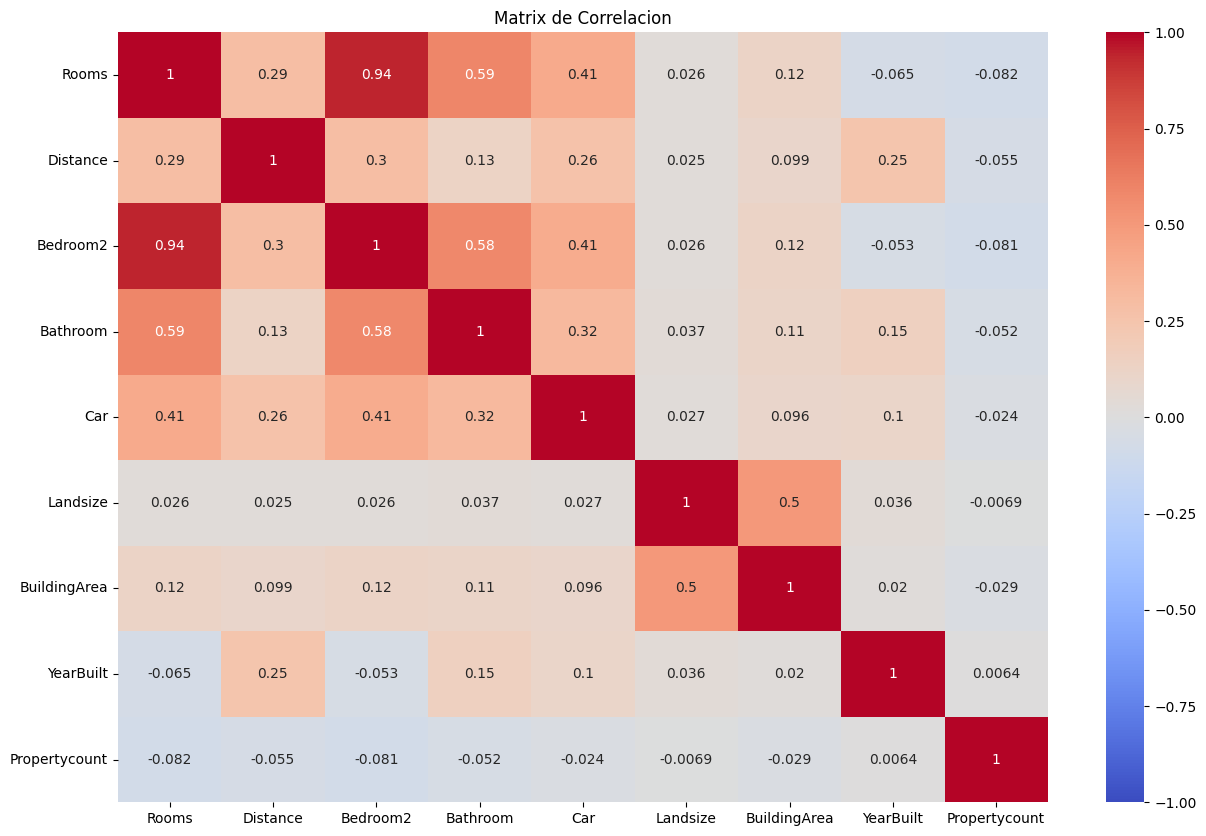

In [336]:
matrix_correlacion = house_data[num_variables].corr()
plt.figure(figsize=(15,10))
sns.heatmap(matrix_correlacion,annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Matrix de Correlacion')
plt.yticks(rotation=0)
plt.show()

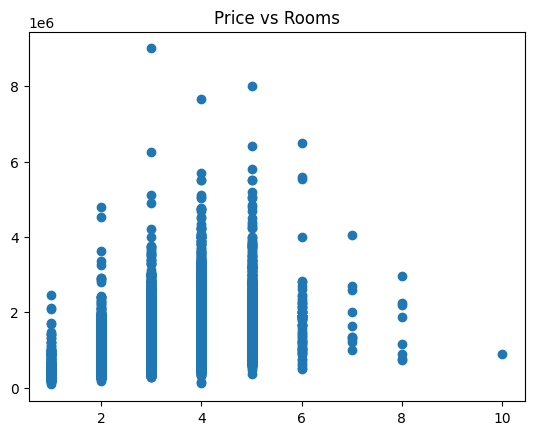

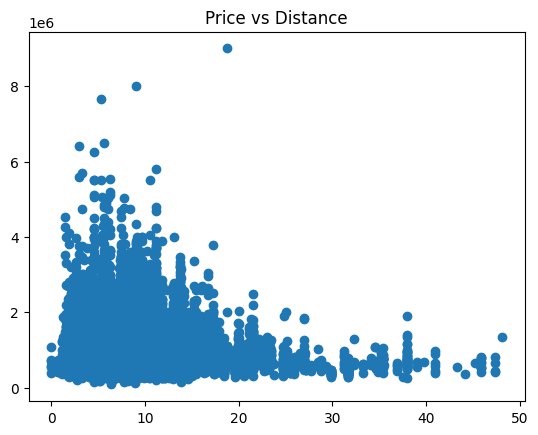

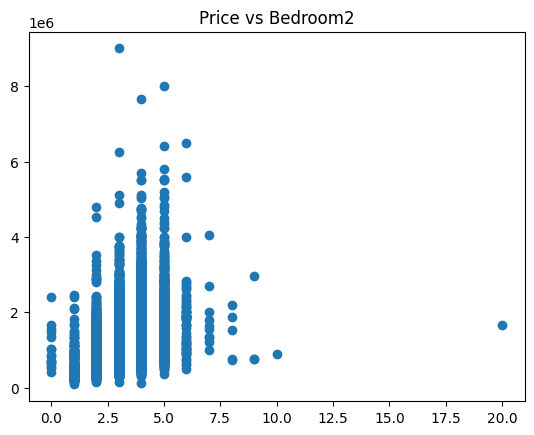

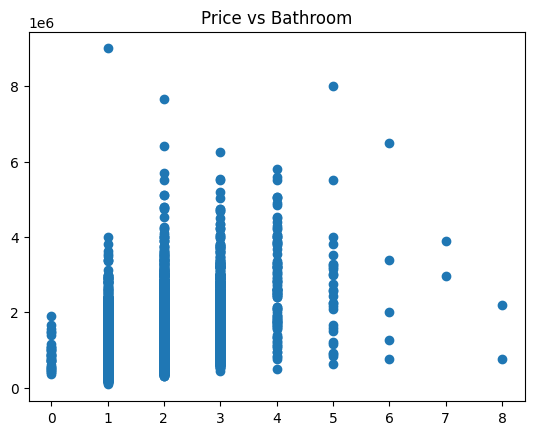

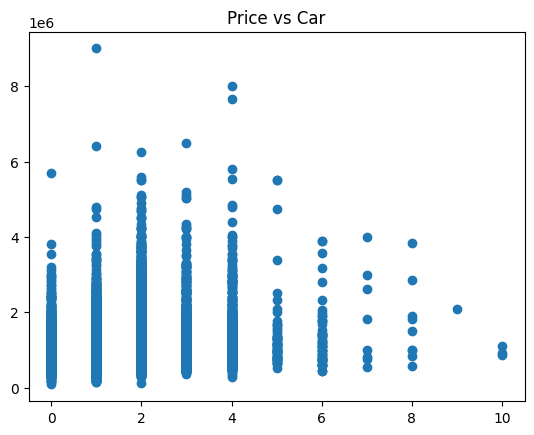

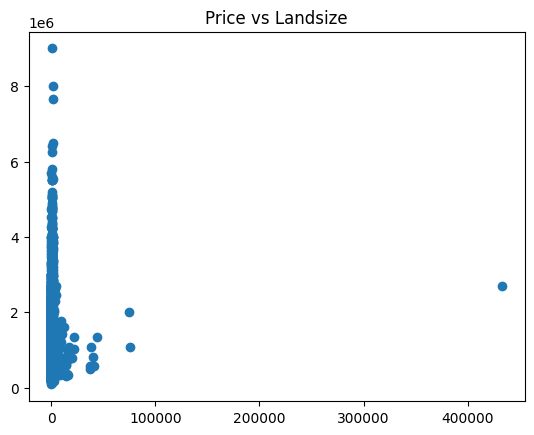

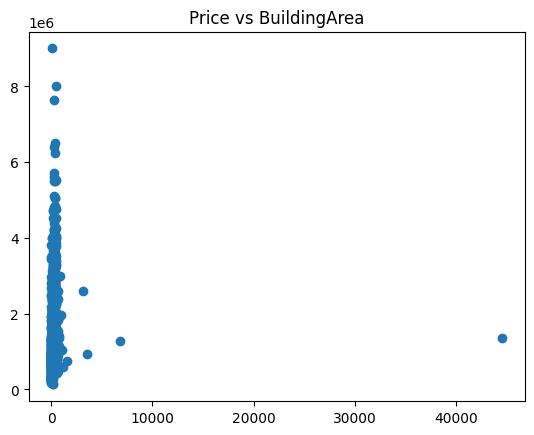

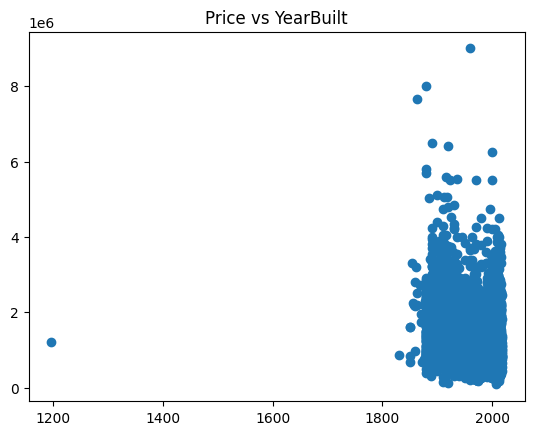

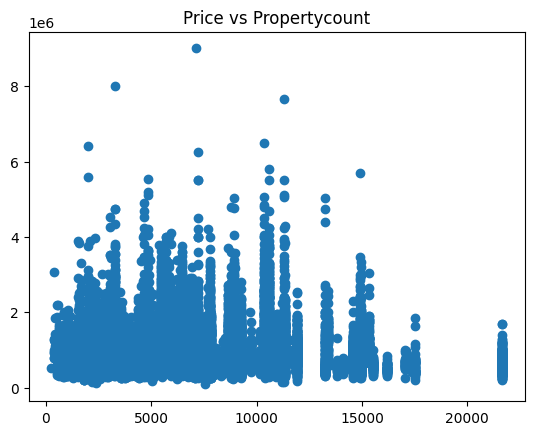

In [337]:
for col_num in num_variables:
    plt.scatter(x=house_data[col_num],y=house_data['Price'])
    plt.title(f'Price vs {col_num}')
    plt.show()

## PROCESAMIENTO DE DATA

In [338]:
# Creacion del PIPELINE con el metodo de IMPUTER para llenar los datos nulos
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

nume_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
]
   )

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', nume_transformer, num_variables),
        ('cat', cat_transformer, cat_variables)
    ],remainder='passthrough',
    n_jobs=-1)
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [339]:
house_data['Price'] = np.log1p(house_data['Price'])
y = house_data['Price']
predictors = num_variables + cat_variables
X = house_data[predictors]

X

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Propertycount,Suburb,Type,Method,SellerG,CouncilArea,Regionname
0,2,2.5,2.0,1.0,1.0,202.0,NaN,NaN,4019.0,Abbotsford,h,S,Biggin,Yarra,Northern Metropolitan
1,2,2.5,2.0,1.0,0.0,156.0,79.0,1900.0,4019.0,Abbotsford,h,S,Biggin,Yarra,Northern Metropolitan
2,3,2.5,3.0,2.0,0.0,134.0,150.0,1900.0,4019.0,Abbotsford,h,SP,Biggin,Yarra,Northern Metropolitan
3,3,2.5,3.0,2.0,1.0,94.0,NaN,NaN,4019.0,Abbotsford,h,PI,Biggin,Yarra,Northern Metropolitan
4,4,2.5,3.0,1.0,2.0,120.0,142.0,2014.0,4019.0,Abbotsford,h,VB,Nelson,Yarra,Northern Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,4,16.7,4.0,2.0,2.0,652.0,NaN,1981.0,7392.0,Wheelers Hill,h,S,Barry,NaN,South-Eastern Metropolitan
13576,3,6.8,3.0,2.0,2.0,333.0,133.0,1995.0,6380.0,Williamstown,h,SP,Williams,NaN,Western Metropolitan
13577,3,6.8,3.0,2.0,4.0,436.0,NaN,1997.0,6380.0,Williamstown,h,S,Raine,NaN,Western Metropolitan
13578,4,6.8,4.0,1.0,5.0,866.0,157.0,1920.0,6380.0,Williamstown,h,PI,Sweeney,NaN,Western Metropolitan


In [340]:
from sklearn import set_config
set_config(transform_output="pandas")
X_prepro = my_pipe.fit_transform(X)

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X_prepro, y, test_size=0.2, random_state=2)
X_train

,num__Rooms,num__Distance,num__Bedroom2,num__Bathroom,num__Car,num__Landsize,num__BuildingArea,num__YearBuilt,num__Propertycount,cat__Suburb_Abbotsford,...,cat__CouncilArea_Yarra,cat__CouncilArea_Yarra Ranges,cat__Regionname_Eastern Metropolitan,cat__Regionname_Eastern Victoria,cat__Regionname_Northern Metropolitan,cat__Regionname_Northern Victoria,cat__Regionname_South-Eastern Metropolitan,cat__Regionname_Southern Metropolitan,cat__Regionname_Western Metropolitan,cat__Regionname_Western Victoria
6941,-0.981463,0.385485,-0.947035,-0.772376,0.406003,0.015683,-1.096146e-01,-0.161685,-0.544584,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12969,1.111216,-0.449480,1.123604,3.564851,1.447238,-0.003863,2.730497e-01,1.736753,0.413296,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10653,2.157555,2.873340,2.158923,6.456335,1.447238,0.085599,6.641100e-02,-0.161685,-1.121047,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11652,0.064876,1.015969,0.088284,-0.772376,0.406003,0.041995,7.250648e-17,0.000000,-0.608534,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4871,0.064876,-0.960683,0.088284,0.673367,-0.635232,-0.111869,-1.325744e-01,-2.232709,0.059972,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,-0.981463,-0.739162,-0.947035,-0.772376,-0.635232,-0.139936,-2.142095e-01,1.702236,-1.024209,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11798,-0.981463,-1.267405,-0.947035,-0.772376,-0.635232,-0.139936,7.250648e-17,0.000000,1.697549,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6637,0.064876,-0.534680,0.088284,0.673367,0.406003,-0.101845,7.250648e-17,0.000000,-0.208161,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2575,0.064876,-1.131084,0.088284,2.119109,-0.635232,-0.092824,-5.859266e-02,1.218997,-0.276451,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [342]:
#  definimos el modelo
model_rfr = RandomForestRegressor(random_state=2)

In [343]:
param_grid_rfr = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}

In [344]:
model_rfr_cv = GridSearchCV(model_rfr, param_grid_rfr, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')

In [345]:
model_rfr_cv.fit(X_train, y_train)

,estimator,RandomForestR...andom_state=2)
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_split': [3, 5, ...], 'n_estimators': [100, 250, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,500


In [346]:
np.sqrt(-1 * model_rfr_cv.best_score_)

np.float64(0.20361727748858224)

In [347]:
model_rfr_cv.best_params_

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500}

## CONCLUSIONES

De acuerdo a las metricas utilizadas, el modelo no es tan preciso como se requiere. Esto posiblemente a distintos factores, uno de ellos(y uno de los mas importante) es la poca cantidad de features (columnas) que posee la data.

Esto da paso a demostralo usando otra data con mayor cantidad de informacion, con la cual sera posible tener un modelo mas certero para predecir el precio de las viviendas.


# SEGUNDA SECCIÓN


En esta segunda seccion se demostrara que con mayor cantidad de informacion proporcionada el modelo tendra mayor cantidad de informacion para tener mejores predicciones.
Al igual que en la primera seccion, se tiene que realizar un pre-procesamiento de la data, realizar un analisis exploratorio y realizar el procesamiento para obtener el modelo.

In [253]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from category_encoders.target_encoder import TargetEncoder

from skopt import BayesSearchCV
from skopt.space import Real,Categorical, Integer
import seaborn as sns
import numpy as np

In [254]:
train_data = pd.read_csv('train_secc_2.csv')
test_data = pd.read_csv('test.csv')


## PRE-PROCESAMIENTO

In [255]:
print(train_data.shape)
print(test_data.shape)
print(train_data.columns)

(1460, 81)
(1459, 80)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'Ga

In [256]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [257]:
# Obtención de las columnas numéricas para realizar un análisis exploratorio básico
train_data.dtypes[train_data.dtypes != 'object']

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

Se procede a graficar los features numéricos para saber si es necesario eliminar valores extremos. 
Para fines de visualizar el procedimento de eliminación de outlets, se presentan un par de ejemplos de las columnas estudiadas.

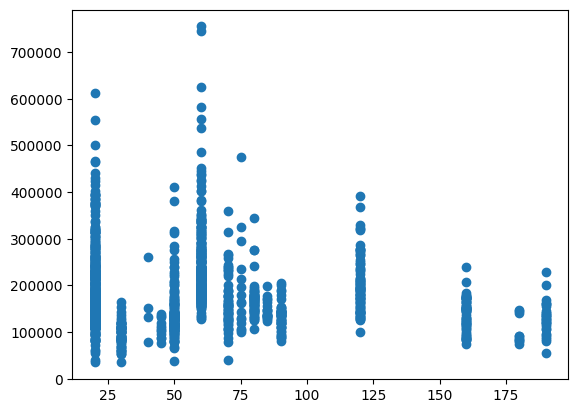

In [258]:
plt.scatter(x='MSSubClass', y='SalePrice',data=train_data)
plt.show()

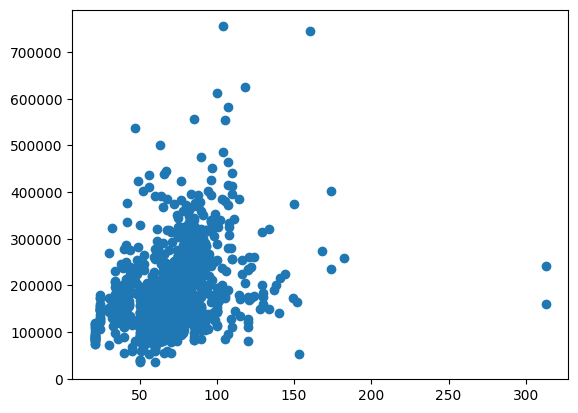

In [259]:
plt.scatter(x='LotFrontage', y='SalePrice', data=train_data)
plt.show()

In [260]:
train_data.query('LotFrontage > 300')
# Basado en el resultado anterior se puede observar que los valores mayores a 300 son outliers
# Se elimina los Ids[935, 1299]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


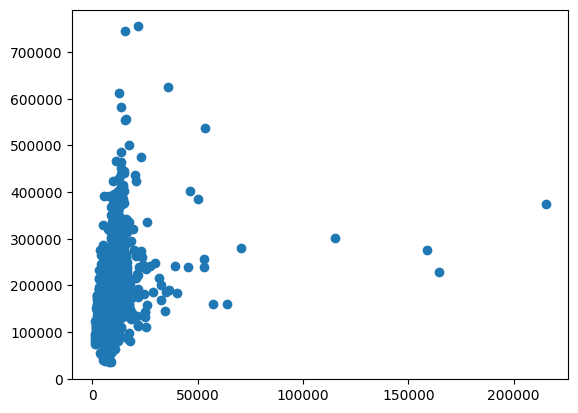

In [261]:
plt.scatter(x='LotArea', y='SalePrice', data=train_data)
plt.show()

In [262]:
train_data.query('LotArea > 55000')
# Se eliminan los IDs 250, 314, 336, 707, 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,1397,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000


In [263]:
num_cols = [cols for cols in train_data.columns if train_data[cols].dtype != 'object']
print(num_cols)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


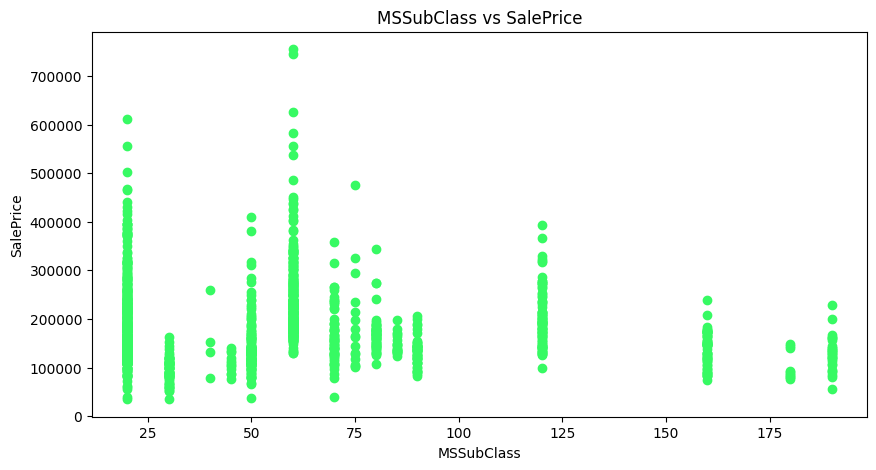

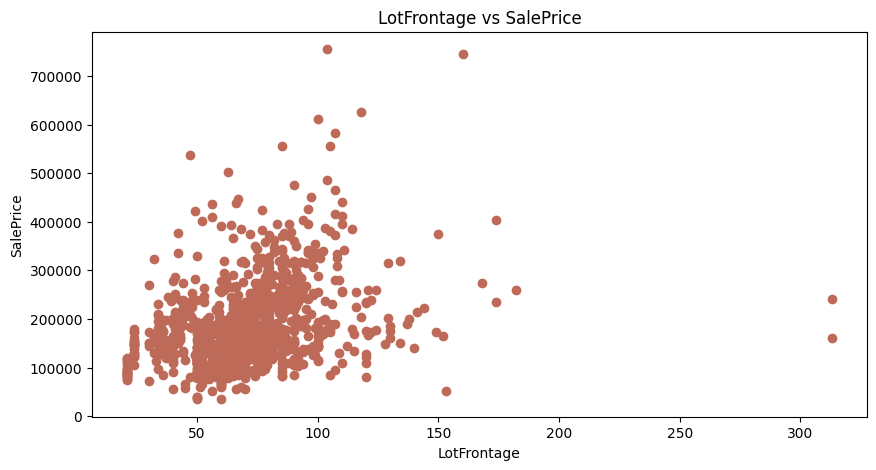

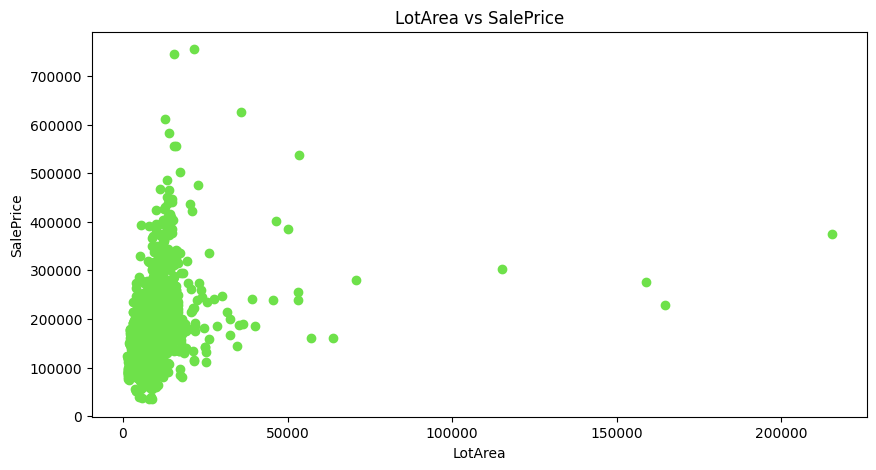

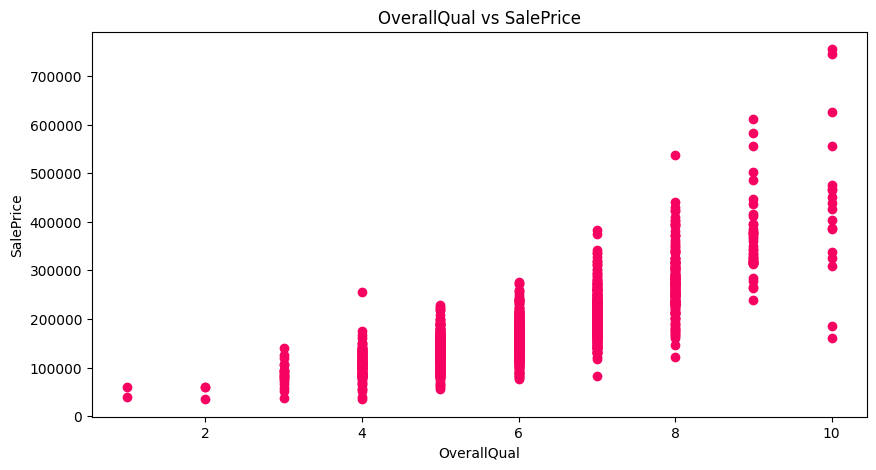

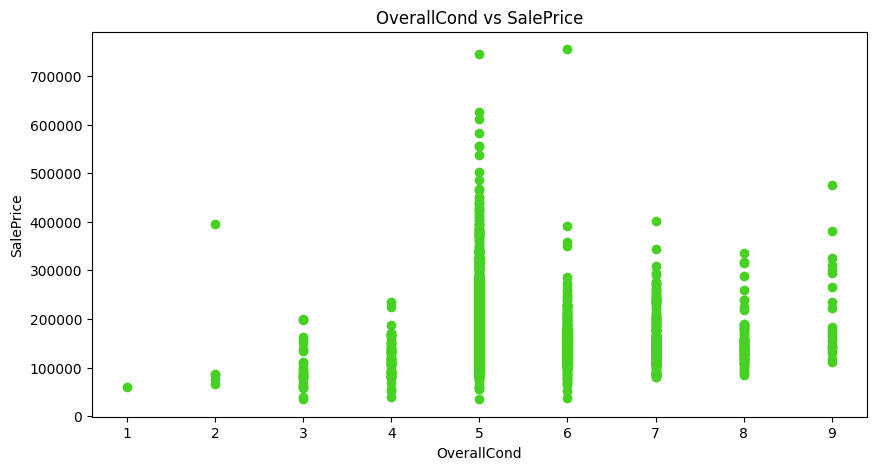

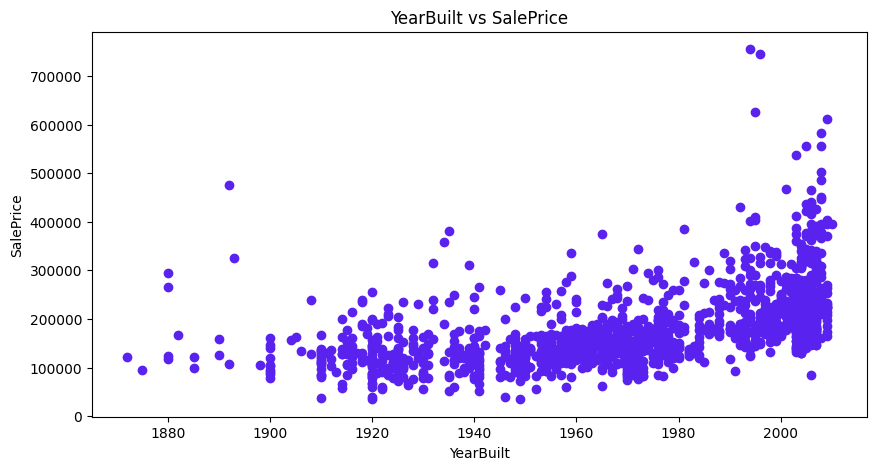

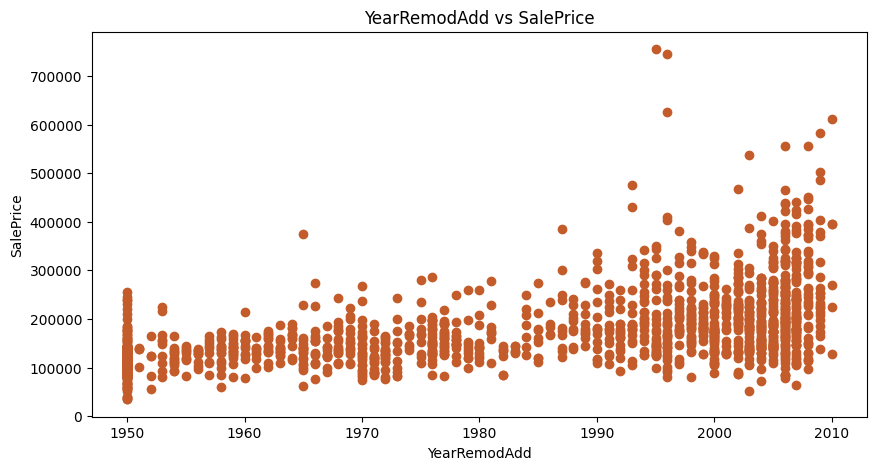

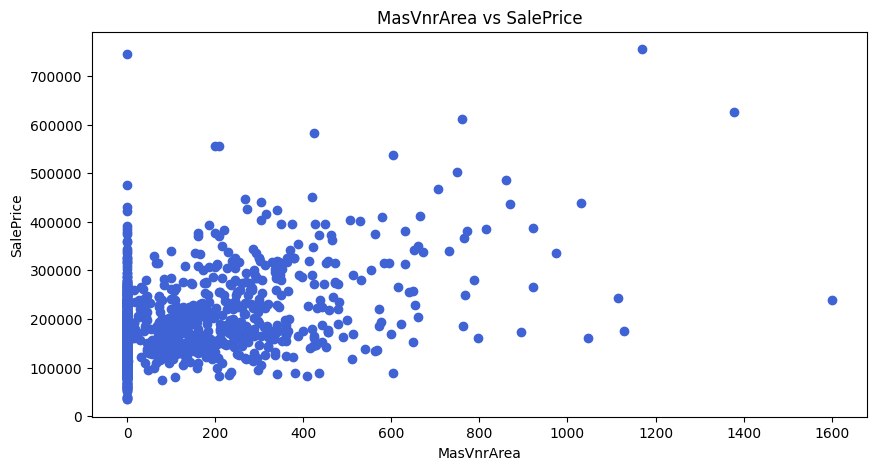

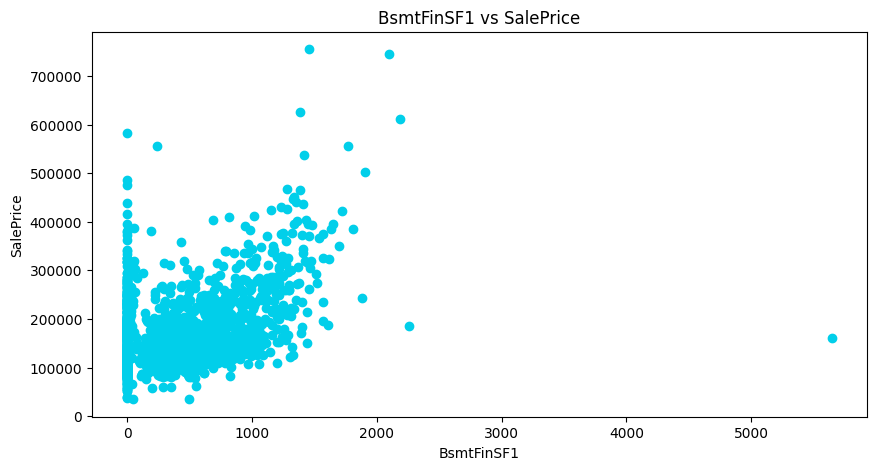

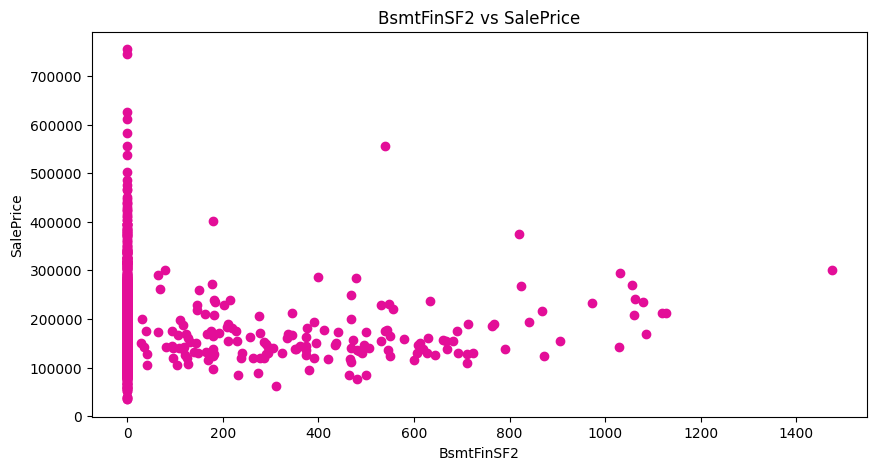

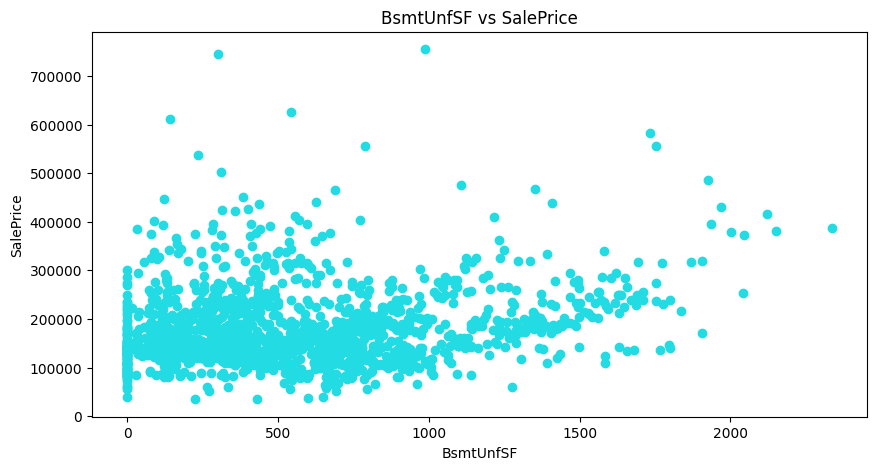

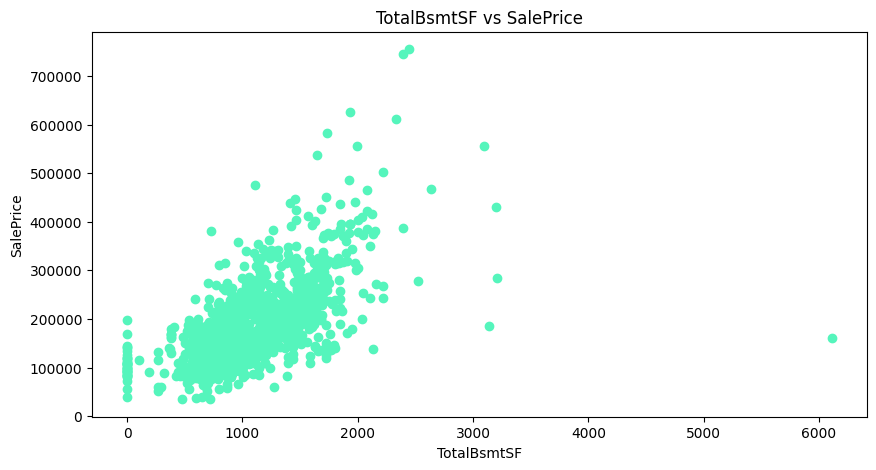

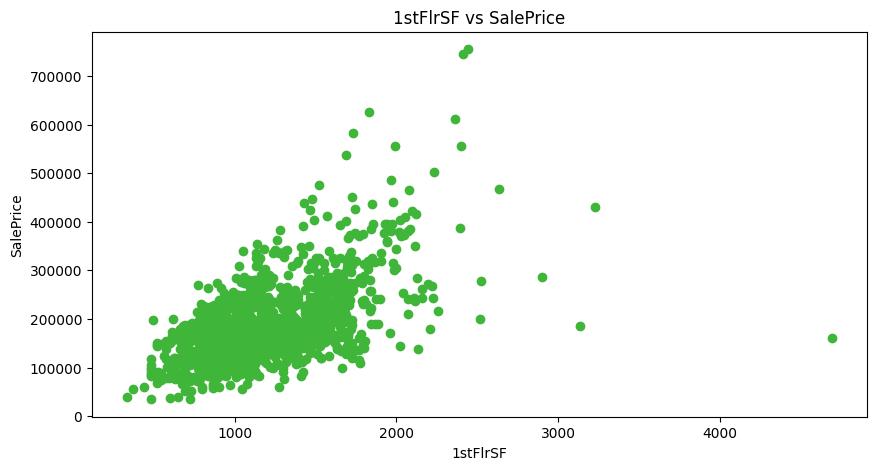

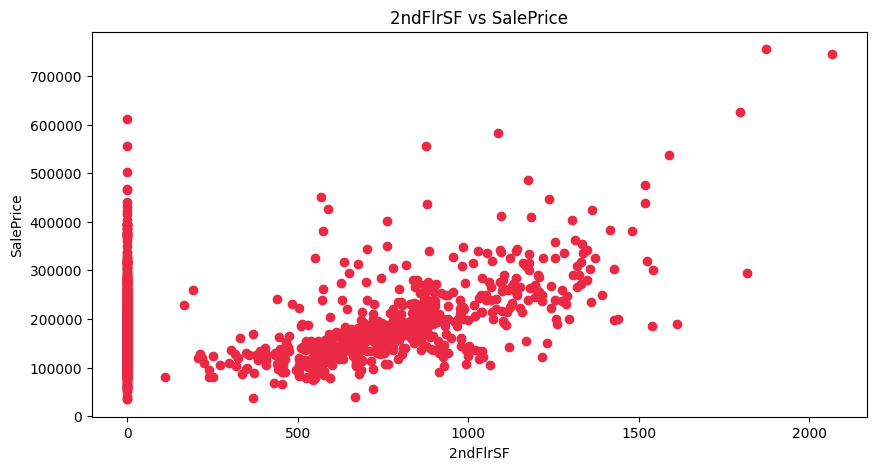

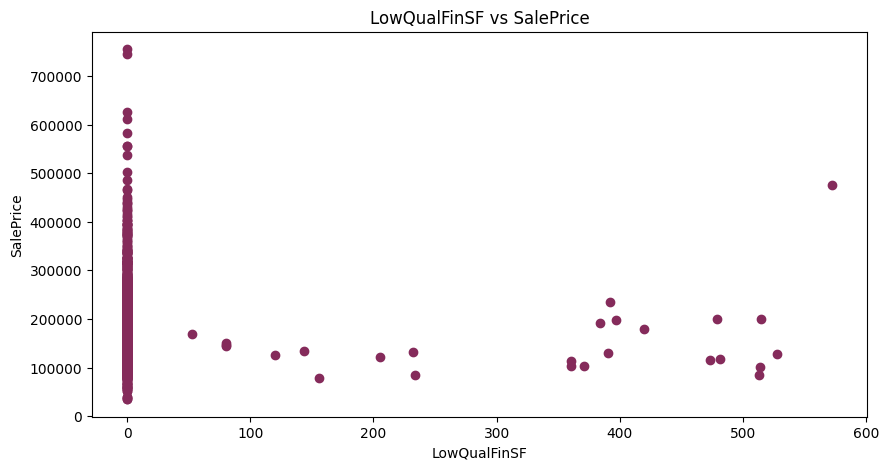

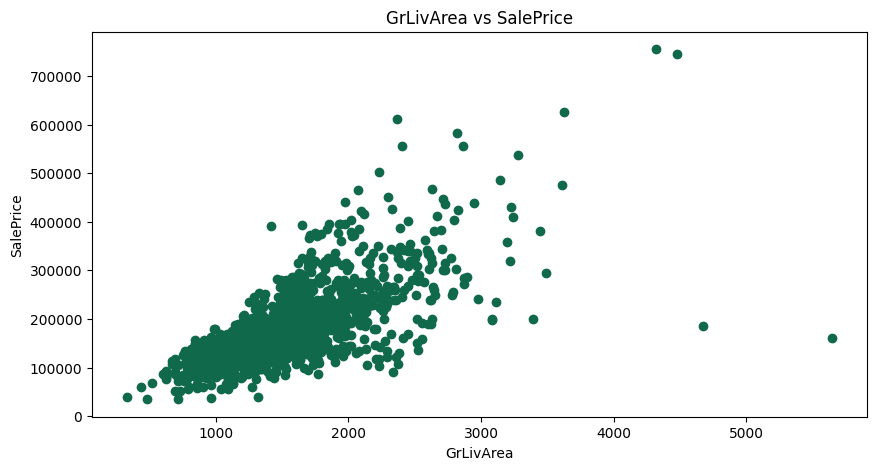

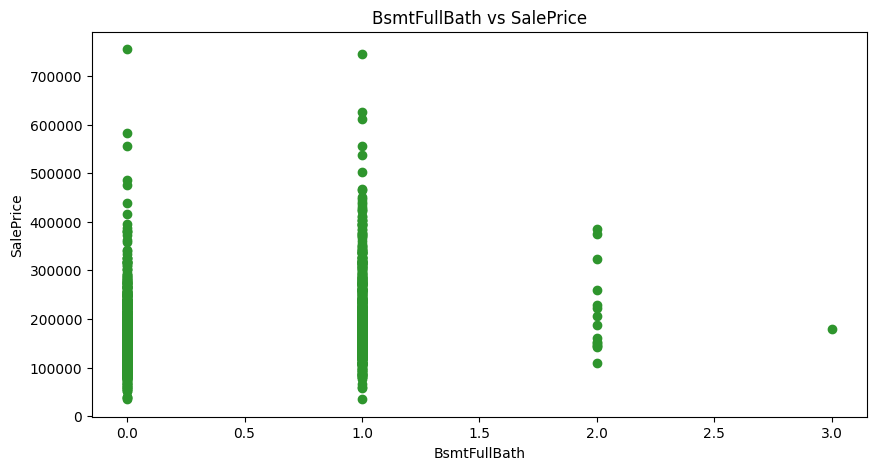

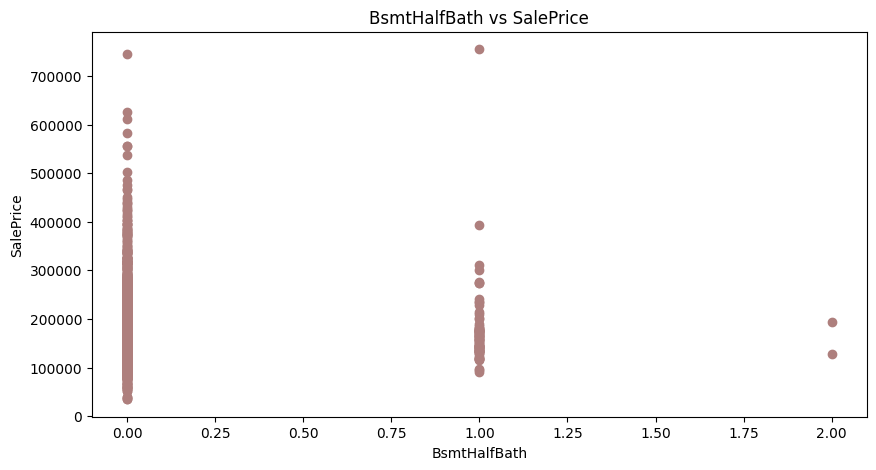

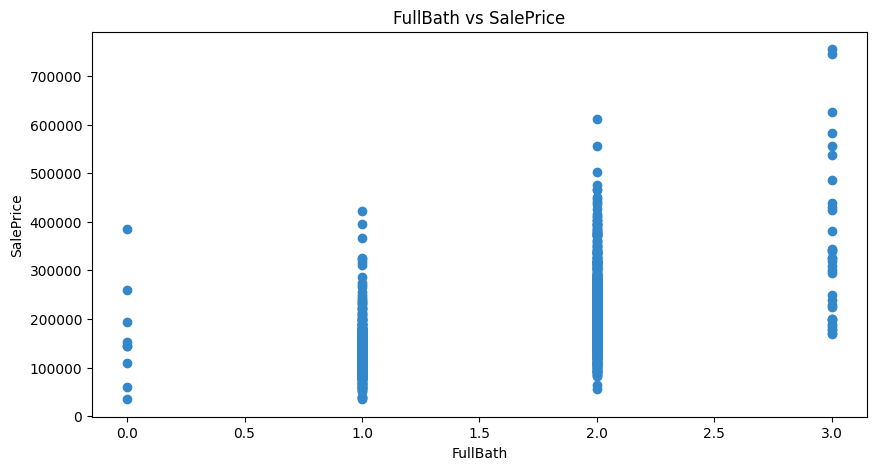

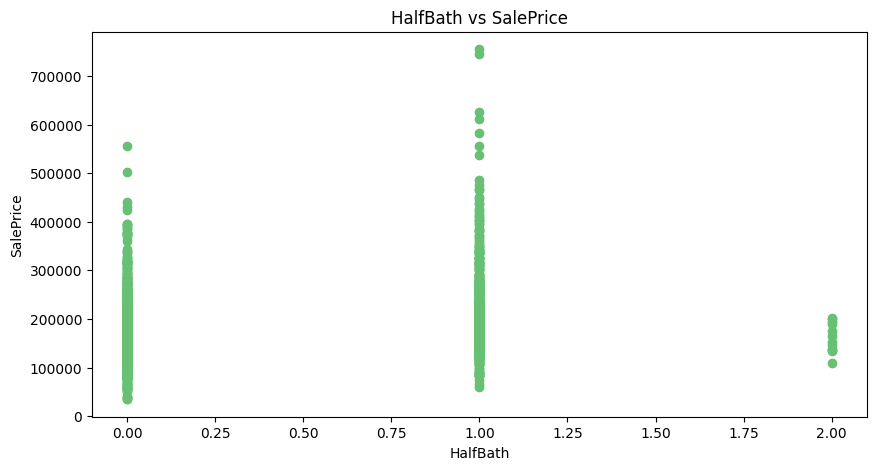

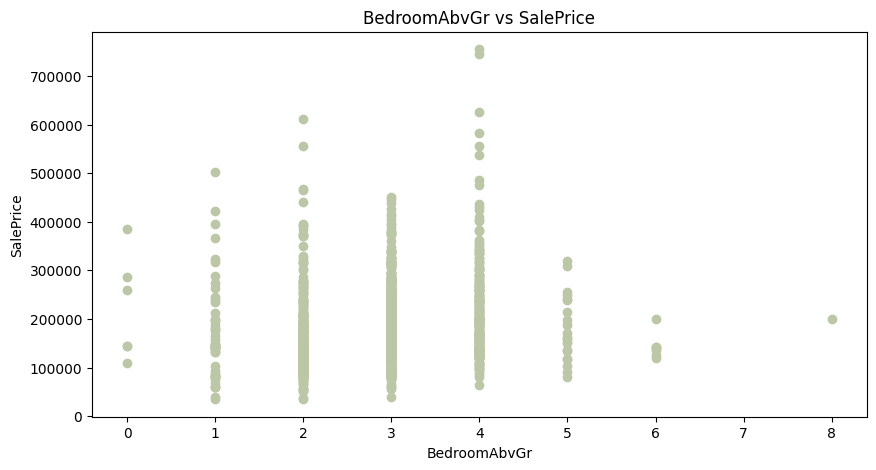

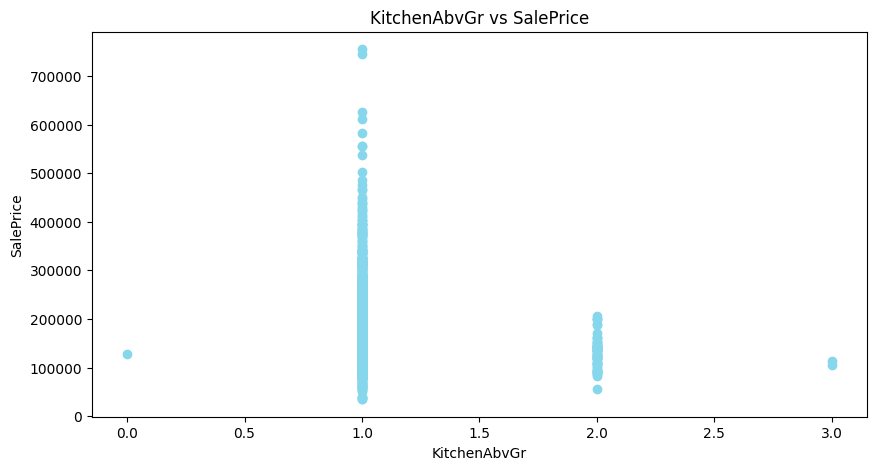

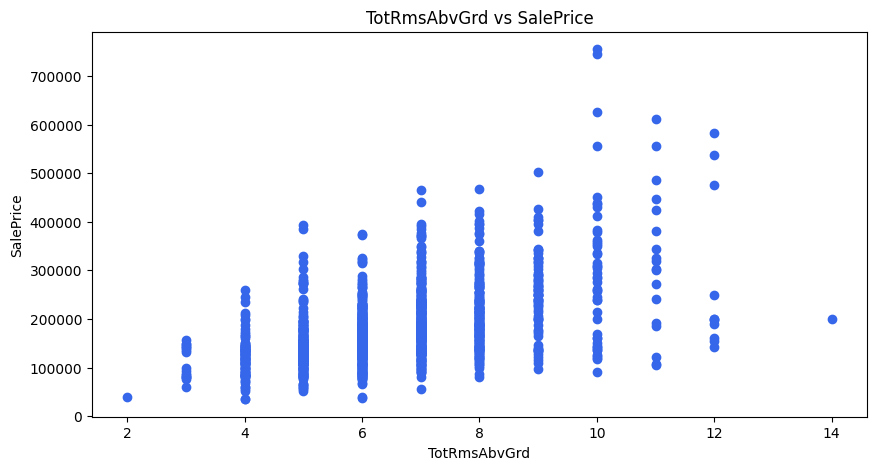

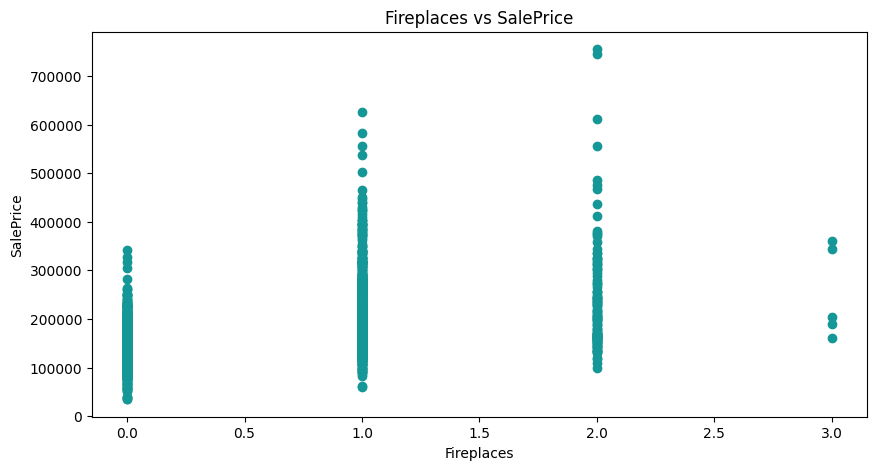

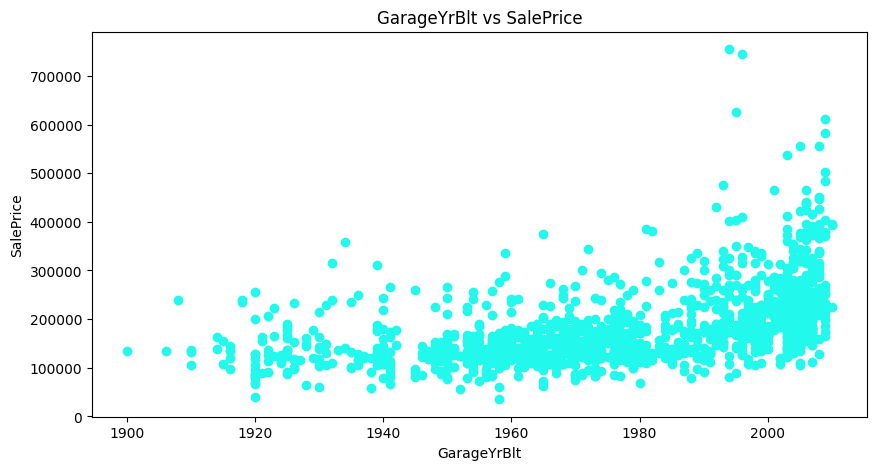

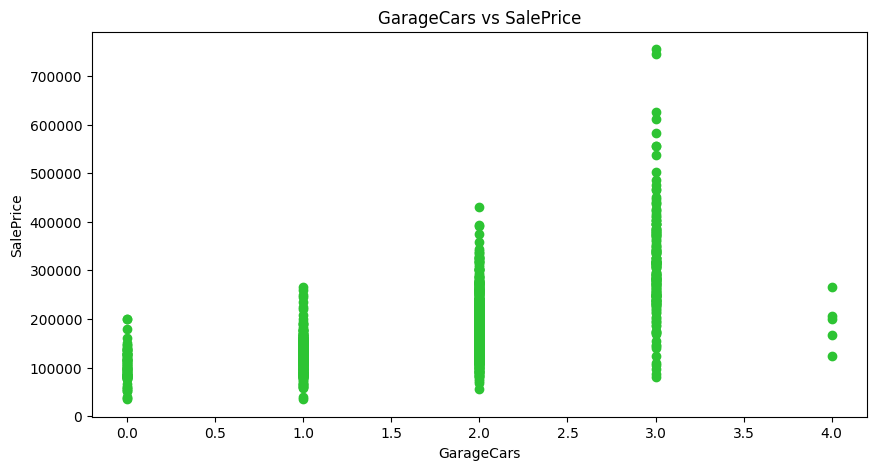

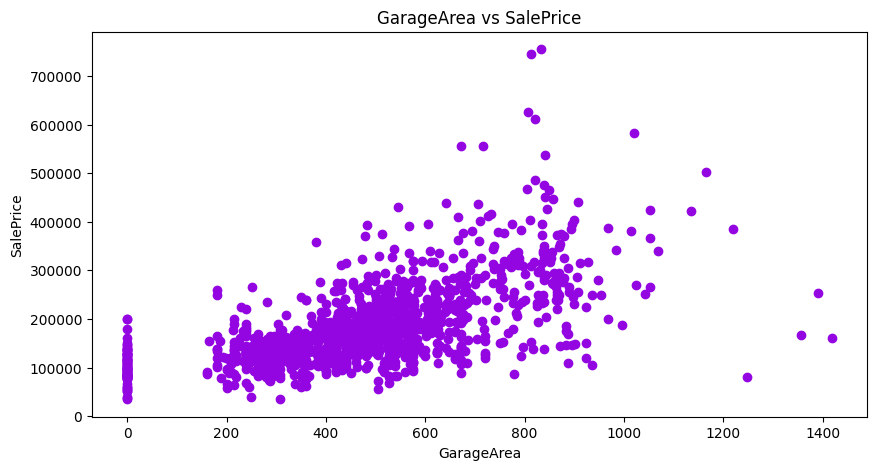

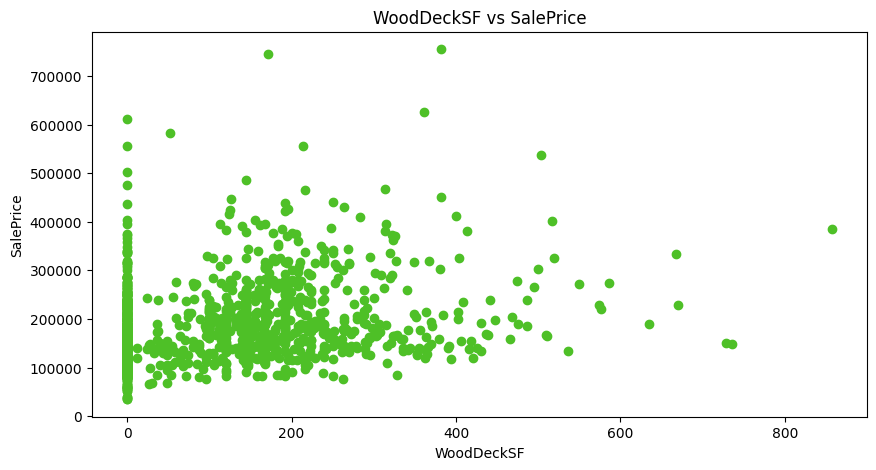

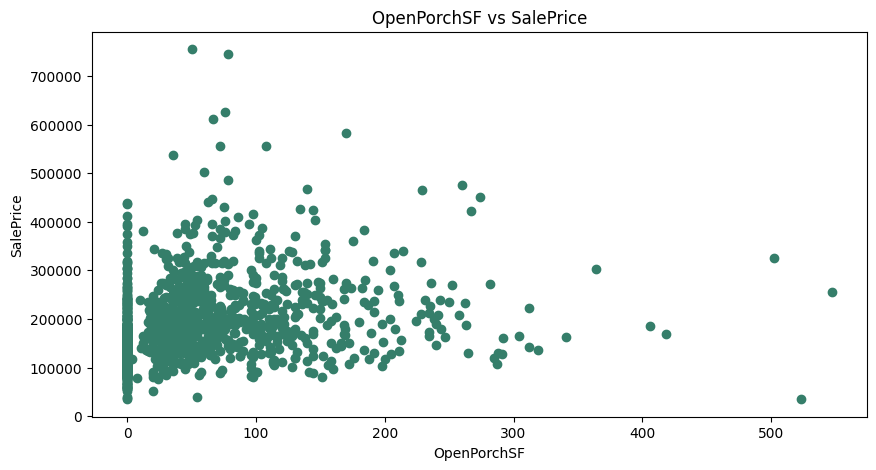

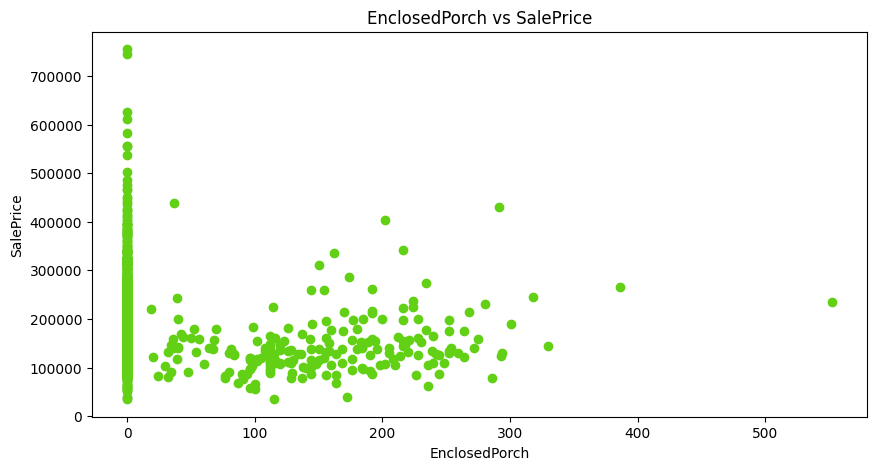

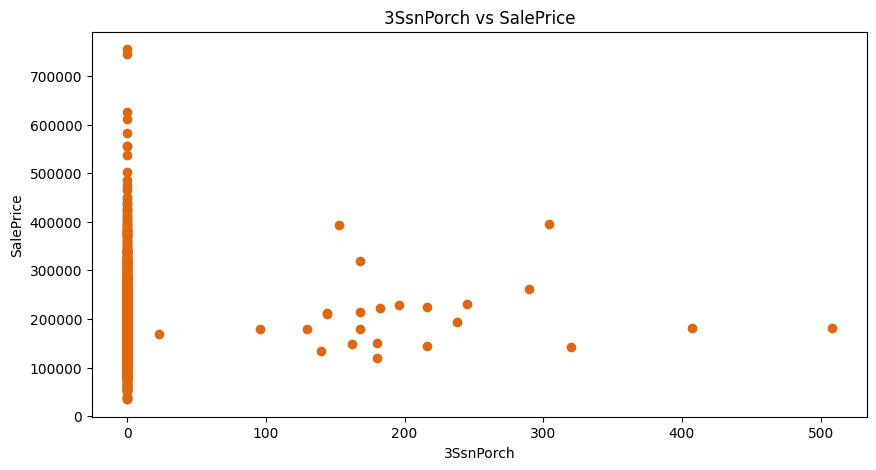

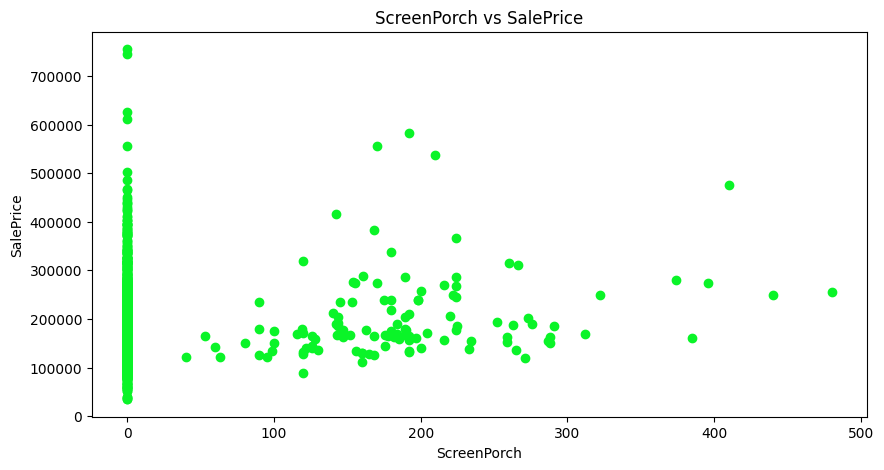

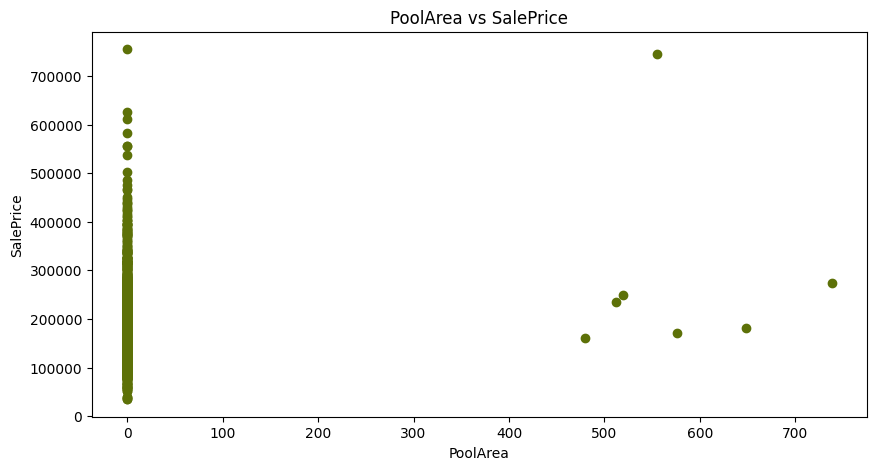

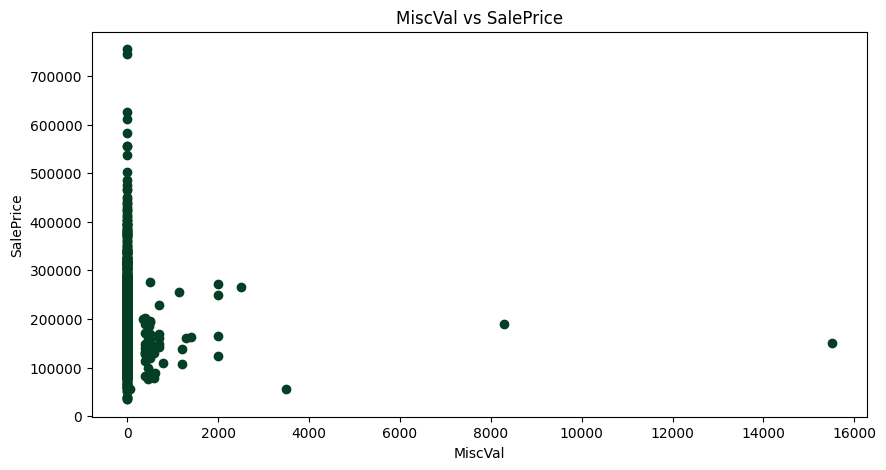

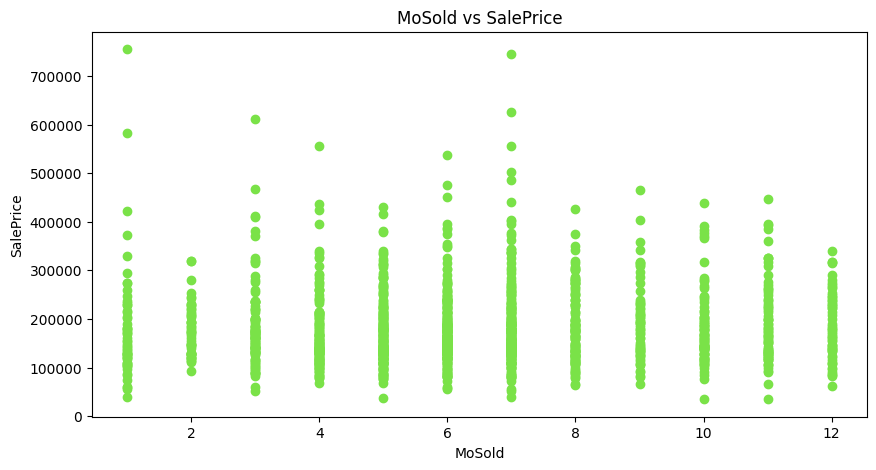

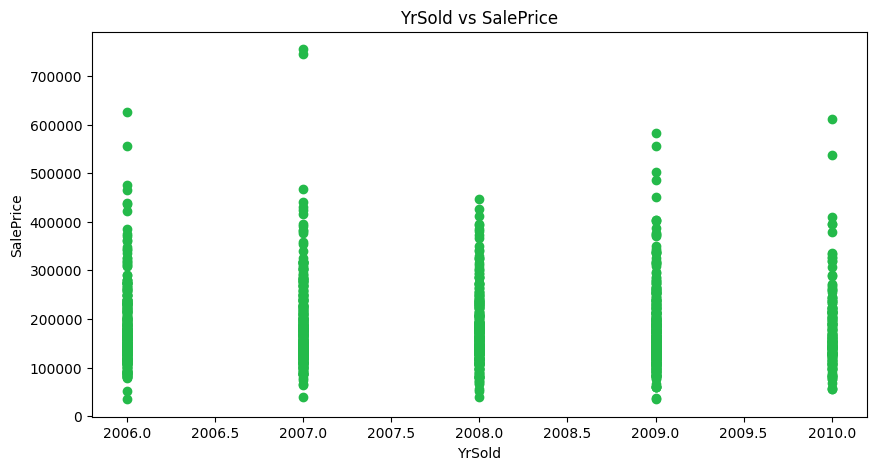

In [264]:
import random
def generate_random_color():
    r = random.random()
    g= random.random()
    b = random.random()
    return (r,g,b)
colors = generate_random_color()

for col in num_cols[1:]:
    if col == 'SalePrice':
        continue
    else :
        plt.figure(figsize=(10,5))
        plt.scatter(x=train_data[col], y=train_data['SalePrice'],color=generate_random_color())
        plt.title(f'{col} vs SalePrice')
        plt.xlabel(col)
        plt.ylabel('SalePrice')
        plt.show()

Luego de analizar las gráficas, se procede a eliminar las filas que contienen los valores extremos para cada columna numérica

In [265]:
id_drop = [598, 955, 935, 1299, 250, 314, 336,
           707, 379, 1183, 692, 186, 441, 186, 524, 739,
          598, 955, 636, 1062, 1191, 496, 198, 1338]

In [266]:
train_data = train_data[train_data.Id.isin(id_drop) == False]

In [267]:
pd.DataFrame(train_data.isnull().sum().sort_values(ascending=False)).head(20)
# Notamos que la mayoria de data faltante pertenece a las columnas categóricas
# Las columnas numéricas con datos nulos son rellenadas con valor 0.
# Debido a que PoolQC tiene 1435 data nula , se decide eliminarla

,0
PoolQC,1435
MiscFeature,1388
Alley,1350
Fence,1162
MasVnrType,861
FireplaceQu,684
LotFrontage,255
GarageQual,76
GarageFinish,76
GarageType,76


El obejtivo de analizar las columnas con valores nulos es tratar de preservalos manteniendo el orden que estas ya poseen, el análisis esta basado en la descripcción de las columnas y sus valores categóricos.
Se trata de llenar los valores NaN con alguna categoría ya existente dentro de cada feature o con el valor "no"

In [268]:
train_data['MiscFeature'].unique()
# Se obseva valores nan , esta columna no es de importancia y podría ser eliminada

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

[nan 'Fa' 'Gd']


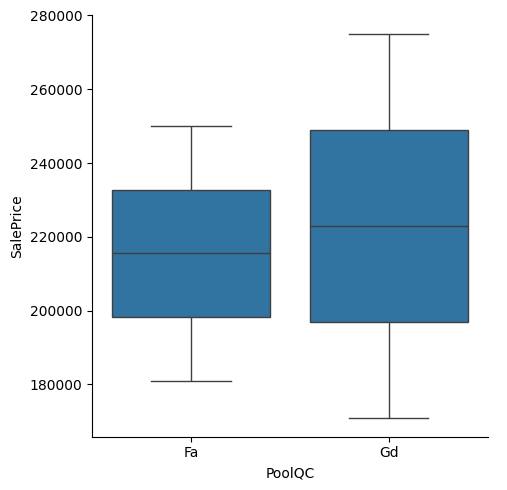

In [269]:
print(train_data['PoolQC'].unique())


sns.catplot(data=train_data, x="PoolQC", y="SalePrice", kind="box")
plt.show()

In [270]:
train_data['Alley'].unique()
train_data['Alley'] = train_data['Alley'].fillna('No')
test_data['Alley'] = test_data['Alley'].fillna('No')


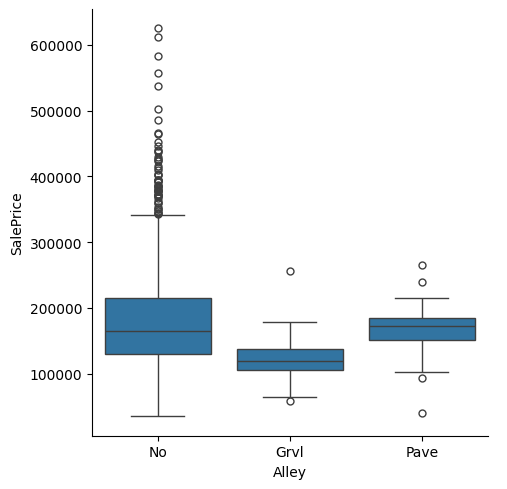

In [271]:
sns.catplot(data=train_data, x="Alley", y="SalePrice", kind="box")
plt.show()
# Debido a que la cantidad de valores "no" agregados es mucho mayor a los otros, se decide eliminarla.
# Esta metodología es aplicada para todas las columnas con mucha data nula.

In [272]:
train_data['Fence'].unique()
train_data['Fence']= train_data['Fence'].fillna('No')
test_data['Fence'] = test_data['Fence'].fillna('No')

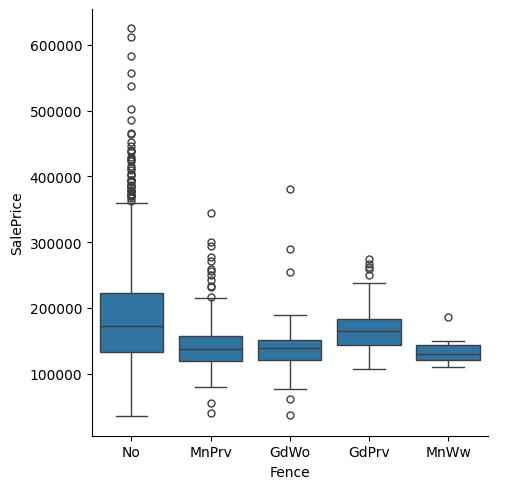

In [273]:
sns.catplot(data=train_data, x="Fence", y="SalePrice", kind="box")
plt.show()

In [274]:
train_data['MasVnrType'].unique()
train_data['MasVnrType']=train_data['MasVnrType'].fillna('No')
test_data['MasVnrType'] = test_data['MasVnrType'].fillna('No')


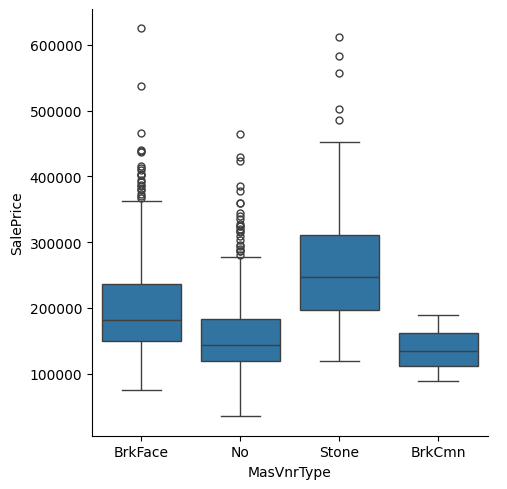

In [275]:
sns.catplot(data=train_data, x="MasVnrType", y="SalePrice", kind="box")
plt.show()
# Como se observa los valores agregados no afectan la cantidad de las otras categorias
# Por lo que se mantiene la columna

In [276]:
train_data['MasVnrArea']=train_data['MasVnrArea'].fillna(0)
test_data['MasVnrArea']=test_data['MasVnrArea'].fillna(0)

In [277]:
train_data['FireplaceQu'].unique()


train_data['FireplaceQu'] = train_data['FireplaceQu'].fillna('No')
test_data['FireplaceQu']= test_data['FireplaceQu'].fillna('No')

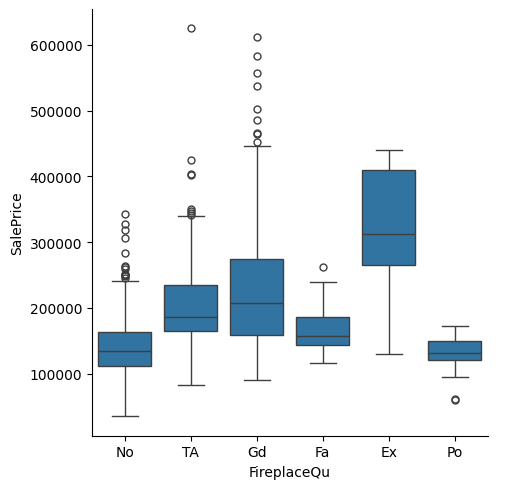

In [278]:
sns.catplot(data=train_data, x="FireplaceQu", y="SalePrice", kind="box")
plt.show()

In [279]:
train_data['LotFrontage']=train_data['LotFrontage'].fillna(0)
test_data['LotFrontage']=test_data['LotFrontage'].fillna(0)

In [280]:
train_data['GarageCond'].unique()

train_data['GarageCond']=train_data['GarageCond'].fillna('No')
test_data['GarageCond']=test_data['GarageCond'].fillna('No')

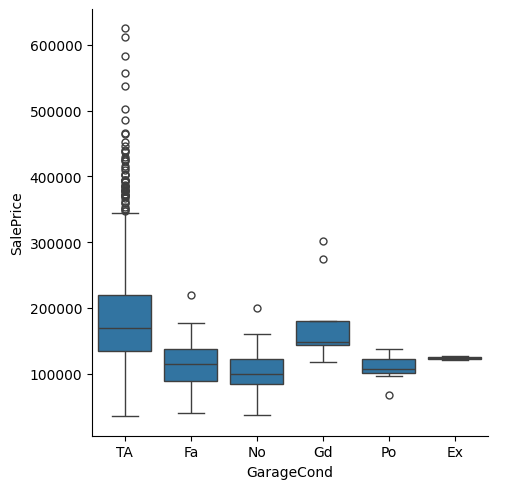

In [281]:
sns.catplot(data=train_data, x="GarageCond", y="SalePrice", kind="box")
plt.show()

In [282]:
train_data['GarageType'].unique()
train_data['GarageType']= train_data['GarageType'].fillna('No')
test_data['GarageType']= test_data['GarageType'].fillna('No')

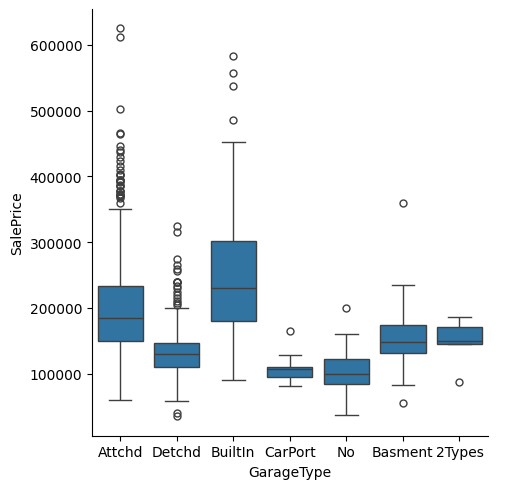

In [283]:
sns.catplot(data=train_data, x="GarageType", y="SalePrice", kind="box")
plt.show()

In [284]:
train_data['GarageType'].unique()
train_data['GarageFinish']=train_data['GarageFinish'].fillna('No')
test_data['GarageFinish']= test_data['GarageFinish'].fillna('No')

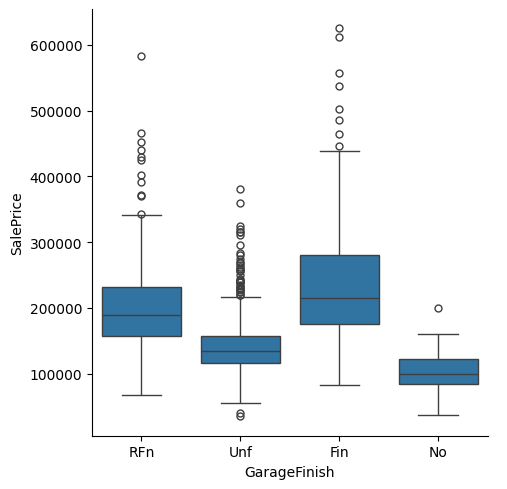

In [285]:
sns.catplot(data=train_data , x="GarageFinish", y="SalePrice", kind="box")
plt.show()

In [286]:
train_data['GarageQual'].unique()
train_data['GarageQual']=train_data['GarageQual'].fillna('No')
test_data['GarageQual']=test_data['GarageQual'].fillna('No')

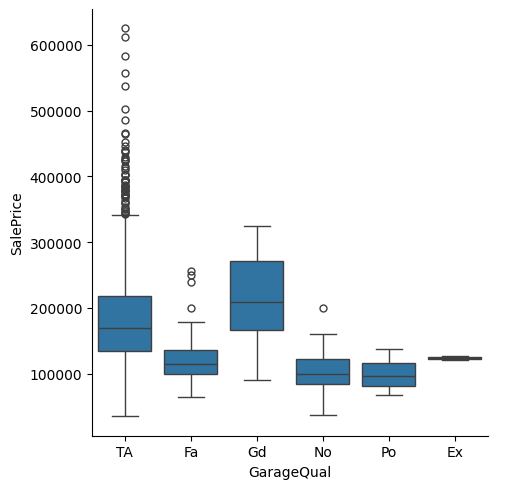

In [287]:
sns.catplot(data=train_data, x="GarageQual", y="SalePrice", kind="box")
plt.show()

In [288]:
train_data['BsmtFinType2'].unique()
train_data['BsmtFinType2']= train_data['BsmtFinType2'].fillna('Unf')
test_data['BsmtFinType2']= test_data['BsmtFinType2'].fillna('Unf')

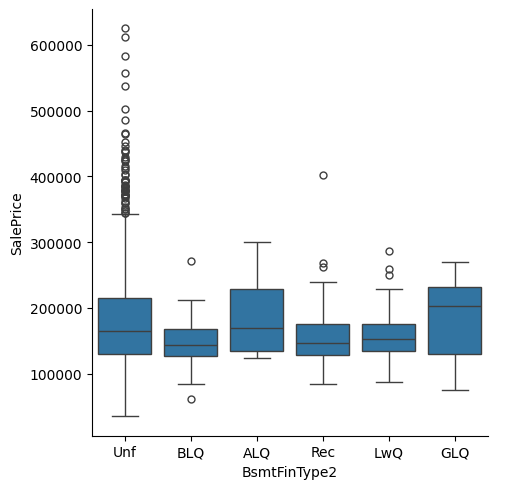

In [289]:
sns.catplot(data=train_data, x="BsmtFinType2", y="SalePrice", kind="box")
plt.show()

In [290]:
train_data['BsmtExposure'].unique()

train_data['BsmtExposure']= train_data['BsmtExposure'].fillna('No')
test_data['BsmtExposure']= test_data['BsmtExposure'].fillna('No')

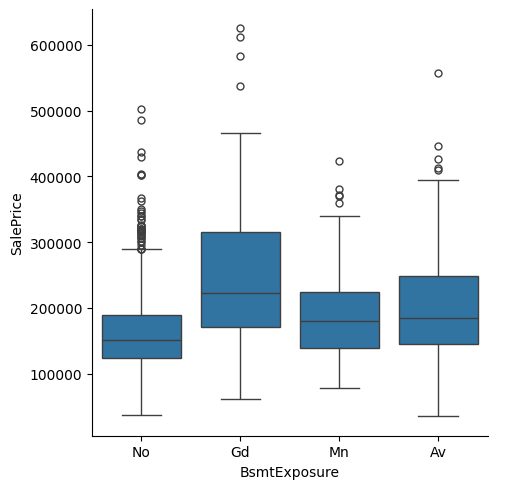

In [291]:
sns.catplot(data=train_data, x="BsmtExposure", y="SalePrice", kind="box")
plt.show()

In [292]:
train_data['BsmtQual'].unique()

train_data['BsmtQual'] = train_data['BsmtQual'].fillna('No')
test_data['BsmtQual']= test_data['BsmtQual'].fillna('No')

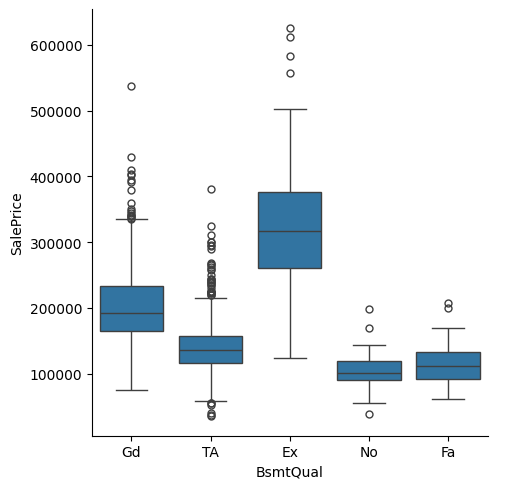

In [293]:
sns.catplot(data=train_data, x="BsmtQual", y="SalePrice", kind="box")
plt.show()

In [294]:


train_data['BsmtCond'].unique()

train_data['BsmtCond']= train_data['BsmtCond'].fillna('No')
test_data['BsmtCond'] =test_data['BsmtCond'].fillna('No')


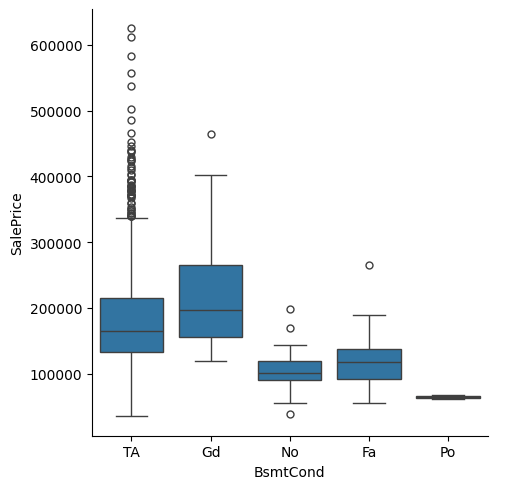

In [295]:
sns.catplot(data=train_data, x="BsmtCond", y="SalePrice", kind="box")
plt.show()

In [296]:
train_data['BsmtFinType1'].unique()

train_data['BsmtFinType1'] = train_data['BsmtFinType1'].fillna('Unf')
test_data['BsmtFinType1']= test_data['BsmtFinType1'].fillna('Unf')

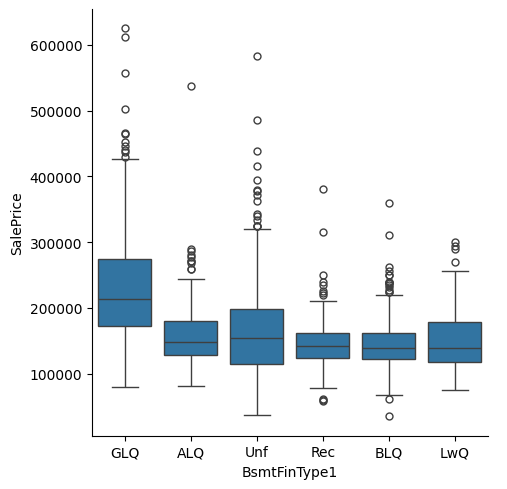

In [297]:
sns.catplot(data=train_data, x="BsmtFinType1", y="SalePrice", kind="box")
plt.show()

In [298]:
train_data['MasVnrArea']=train_data['MasVnrArea'].fillna(0)
test_data['MasVnrArea']=test_data['MasVnrArea'].fillna(0)

In [299]:
train_data['Electrical']=train_data['Electrical'].fillna('SBrkr')
test_data['Electrical']=test_data['Electrical'].fillna('SBrkr')

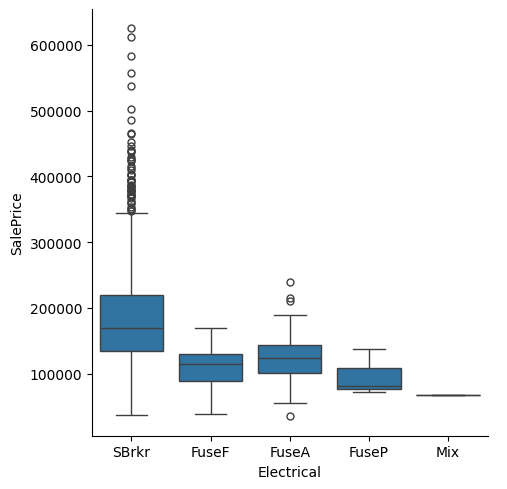

In [300]:
sns.catplot(data=train_data, x="Electrical", y="SalePrice", kind="box")
plt.show()

In [301]:
# Se elimina las columnas que no es posible recuperar por la cantidad de nulos

train_data = train_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_data = test_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])

DEBIDO A LA CANTIDAD ALTA DE FEATURES, MUCHOS DE ELLOS PUEDEN SER USADOS PARA CREAR NUEVOS FEATURES QUE PUEDEN SER ALIMENTADOS AL MODELO PARA TENER UNA MAYOR PRECISIÓN EN LAS PREDICCIONES. ESTE PROCEDIMIENTO ES LLAMADO `FEATURE ENGINEERING`

In [302]:
train_data['houseage'] = train_data['YrSold'] - train_data['YearBuilt']
test_data['houseage'] = test_data['YrSold'] - test_data['YearBuilt']

train_data['houseremodelage'] = train_data['YrSold'] - train_data['YearRemodAdd']
test_data['houseremodelage'] = test_data['YrSold'] - test_data['YearRemodAdd']

train_data['totalsf'] = train_data['1stFlrSF'] + train_data['2ndFlrSF'] + train_data['BsmtFinSF1'] + train_data['BsmtFinSF2']
test_data['totalsf'] = test_data['1stFlrSF'] + test_data['2ndFlrSF'] + test_data['BsmtFinSF1'] + test_data['BsmtFinSF2']

train_data['totalarea'] = train_data['GrLivArea'] + train_data['TotalBsmtSF']
test_data['totalarea'] = test_data['GrLivArea'] + test_data['TotalBsmtSF']

train_data['totalbaths'] = train_data['BsmtFullBath'] + train_data['FullBath'] + 0.5 * (train_data['BsmtHalfBath'] + train_data['HalfBath']) 
test_data['totalbaths'] = test_data['BsmtFullBath'] + test_data['FullBath'] + 0.5 * (test_data['BsmtHalfBath'] + test_data['HalfBath']) 


train_data['totalporchsf'] = train_data['OpenPorchSF'] + train_data['3SsnPorch'] + train_data['EnclosedPorch'] + train_data['ScreenPorch'] + train_data['WoodDeckSF']
test_data['totalporchsf'] = test_data['OpenPorchSF'] + test_data['3SsnPorch'] + test_data['EnclosedPorch'] + test_data['ScreenPorch'] + test_data['WoodDeckSF']

In [303]:
# Se eliminan las columnas inecesarias
train_data = train_data.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test_data = test_data.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

MATRIX DE CORRELACIÓN

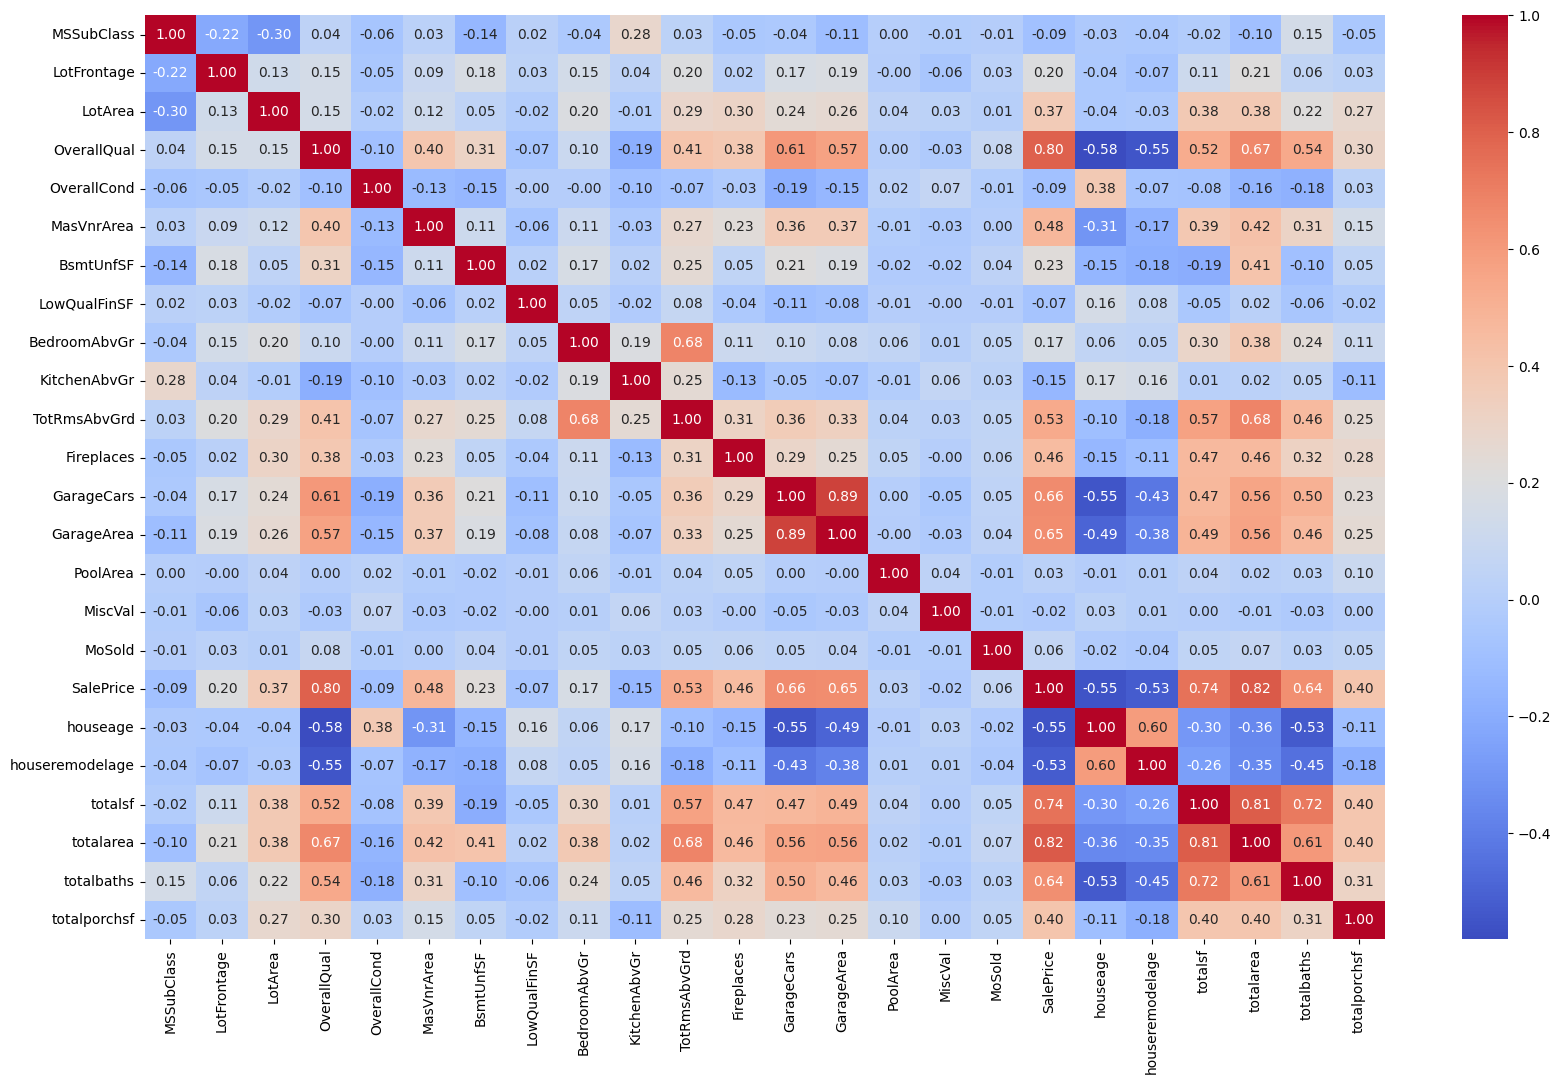

In [304]:
correlation_matrix = train_data.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()
# De acuerdo a la matrix de correlación las variables "GarageCar" y "GarageArea" poseen una 
# alta correlación, por lo que se decide elimnar una de ellas.

In [305]:
train_data = train_data.drop(columns=['GarageArea'])
test_data = test_data.drop(columns=['GarageArea'])

In [306]:
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])

En esta sección se procedió a separar las columnas numéricas y categóricas.
Dentro de las categóricas se separó en categóricas y ordinales

In [307]:
ordi_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  
             'BsmtFinType1',  'CentralAir',  'Functional',
           'FireplaceQu', 'GarageFinish', 'GarageQual', 
           'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure',
           'HeatingQC','ExterQual', 'BsmtCond']

In [308]:
cat_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2',
            'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 
           'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

In [309]:
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

## PROCESAMIENTO DE DATA

In [310]:
# Creación de las pipelines para cada variable (numéricas , categóricas y ordinales)
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ordi_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [311]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ordi_pipeline, ordi_cols),
    ('ohe_p', cat_pipeline, cat_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [312]:
# Se arma el pipeline general
my_pipe = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [313]:
X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

In [314]:
X_preprocessed = my_pipe.fit_transform(X)

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=2)

## CREACIÓN DE MODELOS 

Para este ejemplo se usará 3 modelos.
[Regresion Lineal, Random Forest y XGBost]

REGRESIÓN LINEAL

In [316]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [317]:
y_predi_lr = model_lr.predict(X_test)

In [318]:
mean_squared_error(y_test, y_predi_lr)

0.015207476531249622

RANDOM FOREST

In [319]:
model_rfr = RandomForestRegressor(random_state=2)

In [320]:
param_model_rfr = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}

In [321]:
rfr_gcv = GridSearchCV(model_rfr, param_model_rfr, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')


In [322]:
rfr_gcv.fit(X_train, y_train)

,estimator,RandomForestR...andom_state=2)
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_split': [3, 5, ...], 'n_estimators': [100, 250, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,500


In [323]:
np.sqrt(-1 * rfr_gcv.best_score_)

np.float64(0.13024106326645626)

XGBoost

In [324]:
model_xgb = XGBRegressor(random_state=2)


In [325]:
param_model_xgb = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
}

In [326]:
model_xgb_cv = GridSearchCV(model_xgb, param_model_xgb, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')


In [327]:
model_xgb_cv.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'gamma': [0, 0.1, ...], 'learning_rate': [0.05, 0.1, ...], 'max_depth': [3], 'min_child_weight': [1, 2, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [328]:
np.sqrt(-1 * model_xgb_cv.best_score_)

np.float64(0.11493601744051998)

## CONCLUSIONES

Las métricas indican que entre los modelos analizados XGBoost es el mejor para realizar las predicciones.  

Tambien observamos que en este segundo ejemplo tenemos solo **1460** filas a diferencia de las **13 580** del primer ejemplo. Aún así se obtuvo mejores resultados debido a que en en el segundo ejemplo tenemos **81** features a diferencia de los **21** features del primero.  

Teniendo en cuenta lo importante que es tener una data robusta para obtener mejores resultados en las predicciones.